In [1]:
# パッケージインポート
import os
import re
import collections
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import scipy
import seaborn as sns
import gzip
import glob
import datetime as dt
import gc
import sys
import tqdm as tq
from tqdm import tqdm
import time
import pickle
import sklearn
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn import preprocessing
from sklearn import tree
from six import StringIO
import pydotplus
from IPython.display import Image
import ete3
from ete3 import Tree, TreeStyle, TextFace, PieChartFace, BarChartFace

jpn_fonts=list(np.sort([ttf for ttf in fm.findSystemFonts() if 'ipaexg' in ttf or 'msgothic' in ttf or 'japan' in ttf or 'ipafont' in ttf]))
jpn_font=jpn_fonts[0]
prop = fm.FontProperties(fname=jpn_font)
print(jpn_font)
sns.set()

C:\Windows\Fonts\msgothic.ttc


In [ ]:
import tqdm as tq
from tqdm import tqdm
import ngboost
import mlflow
import umap
import mlxtend
import xgboost.sklearn as xgb
import lightgbm.sklearn as lgb
import networkx
import tensorflow as tf
from tensorflow import keras
import shap
import optuna.integration.lightgbm as opt_lgb
# import lightgbm as lgb_original
import imblearn
from imblearn.under_sampling import RandomUnderSampler
from collections import Counter


jpn_fonts=list(np.sort([ttf for ttf in fm.findSystemFonts() if 'ipaexg' in ttf or 'msgothic' in ttf or 'japan' in ttf or 'ipafont' in ttf]))
jpn_font=jpn_fonts[0]
prop = font_manager.FontProperties(fname=jpn_font)
print(jpn_font)
sns.set()

In [2]:
# データ読み込み
churn=pd.read_csv('WA_Fn-UseC_-Telco-Customer-Churn.csv')
# 半角空白をNanに変更
churn.loc[churn['TotalCharges']==' ', 'TotalCharges']=np.nan
# floatに変更
churn['TotalCharges']=churn['TotalCharges'].astype(float)
churn.dropna(inplace=True)
#print(churn.info())
display(churn.head())

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.50,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [3]:
# LabelEncodingしたデータフレームchurn_encodeを作る
churn_encode=churn.copy()
columns=list(churn_encode.select_dtypes(include=['object']).columns.to_numpy())
for column in columns:
    le = preprocessing.LabelEncoder()
    le.fit(churn_encode[column])
    churn_encode[column] = le.transform(churn_encode[column])
churn_encode=churn_encode.drop('customerID',axis=1)

In [4]:
# 説明変数名
colx=churn_encode.columns.to_numpy()[:-1]
# 目的変数名
coly='Churn'
dfx=churn_encode[colx].copy()# 説明変数
dfy=churn_encode[coly].copy()# 目的変数

In [5]:
churn_encode['Churn']

0       0
1       0
2       1
3       0
4       1
       ..
7038    0
7039    0
7040    0
7041    1
7042    0
Name: Churn, Length: 7032, dtype: int32

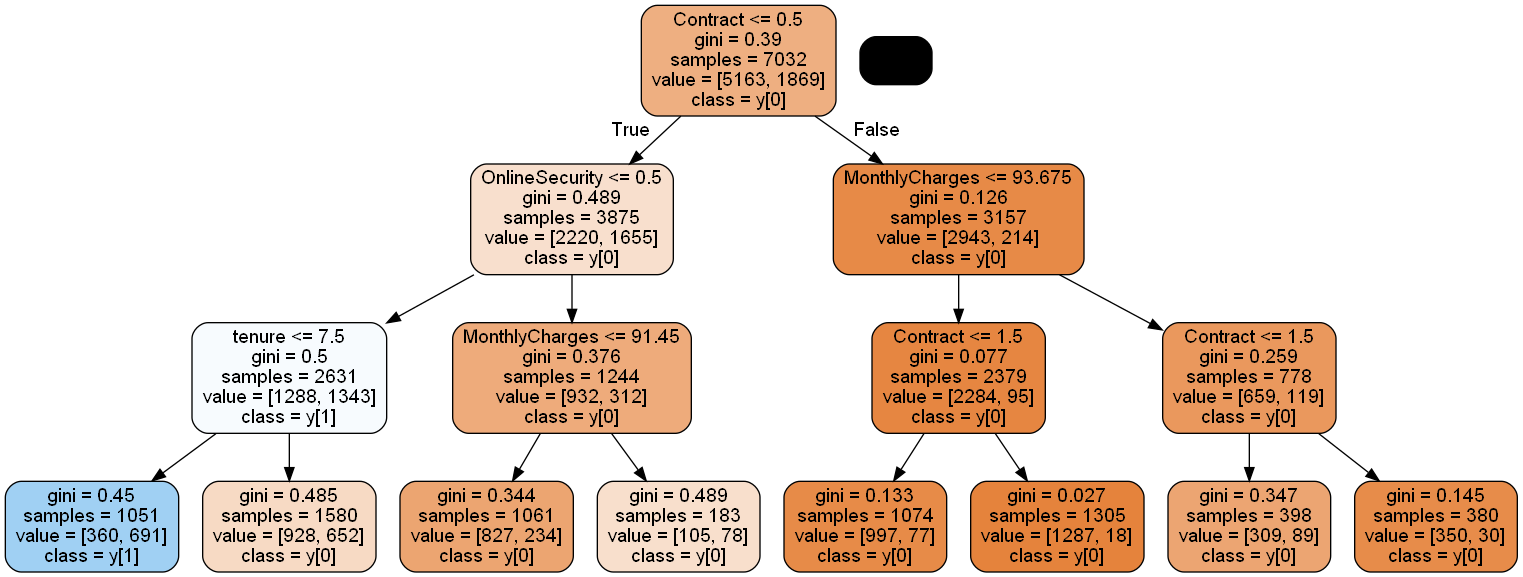

In [6]:
# 決定木モデル構築
clf = sklearn.tree.DecisionTreeClassifier(max_depth=3, random_state=0)
clffit = clf.fit(dfx.to_numpy(), dfy.to_numpy())

# 決定木の可視化
dot_data = StringIO()
sklearn.tree.export_graphviz(clffit, out_file=dot_data
                             , feature_names=colx
                             , class_names=True
                             , filled=True, rounded=True)

graph = pydotplus.graph_from_dot_data(dot_data.getvalue())
Image(graph.create_png())

In [7]:
def make_tree_ete3(clffit, tree_cols, obj_unique, fsize=100, height=300, visual=True, name='tmp'):
    # eteのTreeインスタンスを構築
    tree = Tree()
    
    # node size
    # 各ノードのサンプル数の順に木のノードの大きさを変える
    # tree_.n_node_samplesはノードごとのサンプル数を返す
    nodesize={}
    for i, n in enumerate(np.sort(clffit.tree_.n_node_samples)):
        nodesize[n] = i+1
        
    # 各ノードを設定していく
    # tree_.node_countはノード数を返す
    for i in range(clffit.tree_.node_count):
        #i=0、つまりルートノードの名称を0にする
        if i == 0:
            tree.name = str(0)
        
        # 設定するノードを指定
        # name=str(i)であるete3親ノードの設定をする
        node = tree.search_nodes(name=str(i))[0]
        
        # ノードごとにChurn別の%を計算し、配分の円グラフを作成
        #Graph_Object = PieChartFace(percents=clffit.tree_.value[i][0] / clffit.tree_.value[i].sum() * 100# Churn別の割合
        #                            , width=nodesize[clffit.tree_.n_node_samples[i]]*100# nodesize辞書内の数値×100
        #                            , height=nodesize[clffit.tree_.n_node_samples[i]]*100# nodesize辞書内の数値×100
        #                            , colors=ete3.COLOR_SCHEMES['set2'])# グラフの色
        # ノードごとにChurn別の数を計算し、barグラフを作成
        Graph_Object = BarChartFace(values=clffit.tree_.value[i][0]# Churn別のサンプル数
                                    , width=nodesize[clffit.tree_.n_node_samples[i]]*100# nodesize辞書内の数値×100
                                    , height=nodesize[clffit.tree_.n_node_samples[i]]*100# nodesize辞書内の数値×100
                                    , colors=ete3.COLOR_SCHEMES['set2'])# グラフの色
        Graph_Object.opacity = 0.8
        #Graph_Object.hz_align = 2# 0 left, 1 center, 2 right
        #Graph_Object.vt_align = 2# 0 left, 1 center, 2 right
        
        #グラフをセット
        # position='aligned', 'branch-top', 'float-behind', 'branch-bottom', 'float', 'branch-right'
        node.add_face(Graph_Object, column=2, position="branch-right")

        # 左下の子ノードの設定をする
        if clffit.tree_.children_left[i] > -1:# 左下に子ノードがある場合(-1の時、子ノードはない)
            # ノード名称はsklearnのtreeのリストIDと一致させる
            node.add_child(name=str(clffit.tree_.children_left[i]))# ete3子ノード追加
            # 対象を子ノードに移す
            node = tree.search_nodes(name=str(clffit.tree_.children_left[i]))[0]
            # 分岐条件を追加
            # position='aligned', 'branch-top', 'float-behind', 'branch-bottom', 'float', 'branch-right'
            node.add_face(TextFace(tree_cols[clffit.tree_.feature[i]], fsize=fsize)# 特徴量の名前
                          , column=0, position="branch-top")# Text位置
            node.add_face(TextFace(u"≦" + "{0:.2f}".format(clffit.tree_.threshold[i]), fsize=fsize)# 特徴量の分岐の閾値
                          , column=1, position="branch-bottom")# Text位置
            # 親ノードに対象を戻しておく
            node = tree.search_nodes(name=str(i))[0]
        
        # 右下の子ノードの設定をする
        if clffit.tree_.children_right[i] > -1:# 右下に子ノードがある場合(-1の時、子ノードはない)
            # ノード名称はsklearnのtreeのリストIDと一致させる
            node.add_child(name=str(clffit.tree_.children_right[i]))# ete3子ノード追加
            # 対象を子ノードに移す
            node = tree.search_nodes(name=str(clffit.tree_.children_right[i]))[0]
            # 分岐条件を追加
            # position='aligned', 'branch-top', 'float-behind', 'branch-bottom', 'float', 'branch-right'
            node.add_face(TextFace(tree_cols[clffit.tree_.feature[i]], fsize=fsize)# 特徴量の名前
                          , column=0, position="branch-top")# Text位置
            node.add_face(TextFace(">" + "{0:.2f}".format(clffit.tree_.threshold[i]), fsize=fsize)# 特徴量の分岐の閾値
                          , column=1, position="branch-bottom")# Text位置
            # 親ノードに対象を戻しておく
            node = tree.search_nodes(name=str(i))[0]

        # ノード内のサンプル数や割合をテキストとして記す
        text1 = str(obj_unique[0])+":{0:.0f}".format(clffit.tree_.value[i][0][0] / clffit.tree_.n_node_samples[i] * 100) + "%"
        text1_1 = "{0:.0f}".format(clffit.tree_.n_node_samples[i])
        texts_ary = []
        for obj_i in obj_unique:# 各クラスのサンプル数
            txt = "{:.0f}:{:.0f}".format(obj_i, clffit.tree_.value[i][0][obj_i])
            texts_ary.append(txt)
        
        # 情報を書き込み
        # position='aligned', 'branch-top', 'float-behind', 'branch-bottom', 'float', 'branch-right'
        node.add_face(TextFace(text1_1, fsize=fsize)
                      , column=4, position="branch-right")
        node.add_face(TextFace(text1, fsize=fsize)
                      , column=4, position="branch-right")
        for txt_i in texts_ary:
            node.add_face(TextFace(txt_i, fsize=fsize)
                          , column=4, position="branch-right")

    if visual:
        # 別ウィンドウで可視化
        tree.show()#tree.render("%%inline")#, tree_style=ts)
    else:
        #ファイル保存
        tree.render(name+'.svg', h=height)#, tree_style=ts)

In [14]:
obj_unique = np.sort(dfy.unique())

In [32]:
make_tree_ete3(clffit, colx, obj_unique, fsize=100, height=300, visual=True, name='tmp')

In [42]:
clffit.tree_.threshold

array([ 0.5       ,  0.5       ,  7.5       , -2.        , -2.        ,
       91.44999695, -2.        , -2.        , 93.67499924,  1.5       ,
       -2.        , -2.        ,  1.5       , -2.        , -2.        ])

In [31]:
print(clffit.tree_.n_node_samples)
print(clffit.tree_.node_count)
print(clffit.tree_.value)
print(clffit.tree_.children_left)
print(clffit.tree_.feature)
print(clffit.tree_.threshold)

[7032 3875 2631 1051 1580 1244 1061  183 3157 2379 1074 1305  778  398
  380]
15
[[[5163. 1869.]]

 [[2220. 1655.]]

 [[1288. 1343.]]

 [[ 360.  691.]]

 [[ 928.  652.]]

 [[ 932.  312.]]

 [[ 827.  234.]]

 [[ 105.   78.]]

 [[2943.  214.]]

 [[2284.   95.]]

 [[ 997.   77.]]

 [[1287.   18.]]

 [[ 659.  119.]]

 [[ 309.   89.]]

 [[ 350.   30.]]]
[ 1  2  3 -1 -1  6 -1 -1  9 10 -1 -1 13 -1 -1]
[14  8  4 -2 -2 17 -2 -2 17 14 -2 -2 14 -2 -2]
[ 0.5         0.5         7.5        -2.         -2.         91.44999695
 -2.         -2.         93.67499924  1.5        -2.         -2.
  1.5        -2.         -2.        ]


In [21]:
# eteのTreeインスタンスを構築
tree = Tree()

# node size
# 各ノードのサンプル数の順に木のノードの大きさを変える
# tree_.n_node_samplesはノードごとのサンプル数を返す
nodesize={}
for i, n in enumerate(np.sort(clffit.tree_.n_node_samples)):
    nodesize[n] = i+1
nodesize

{183: 1,
 380: 2,
 398: 3,
 778: 4,
 1051: 5,
 1061: 6,
 1074: 7,
 1244: 8,
 1305: 9,
 1580: 10,
 2379: 11,
 2631: 12,
 3157: 13,
 3875: 14,
 7032: 15}

In [22]:
i=0
fsize=100
#i=0、つまりルートノードの名称を0にする
if i == 0:
    tree.name = str(0)
        
# 設定するノードを指定
# name=str(i)であるete3親ノードの設定をする
node = tree.search_nodes(name=str(i))[0]

In [23]:
clffit.tree_.value[i][0]

array([5163., 1869.])

In [24]:
# ノードごとにChurn別の数を計算し、barグラフを作成
Graph_Object = BarChartFace(values=clffit.tree_.value[i][0]# Churn別のサンプル数
                            , width=nodesize[clffit.tree_.n_node_samples[i]]*100# nodesize辞書内の数値×100
                            , height=nodesize[clffit.tree_.n_node_samples[i]]*100# nodesize辞書内の数値×100
                            , colors=ete3.COLOR_SCHEMES['set2'], scale_fsize=0)# グラフの色
Graph_Object.opacity = 0.8
#Graph_Object.hz_align = 1# 0 left, 1 center, 2 right
#Graph_Object.vt_align = 1# 0 left, 1 center, 2 right
# グラフをセット
# position='aligned', 'branch-top', 'float-behind', 'branch-bottom', 'float', 'branch-right'
node.add_face(Graph_Object, column=2, position="branch-right")

In [25]:
# 左下の子ノードの設定をする
if clffit.tree_.children_left[i] > -1:# 左下に子ノードがある場合(-1の時、子ノードはない)
    # ノード名称はsklearnのtreeのリストIDと一致させる
    node.add_child(name=str(clffit.tree_.children_left[i]))# ete3子ノード追加
    # 対象を子ノードに移す
    node = tree.search_nodes(name=str(clffit.tree_.children_left[i]))[0]
    # 分岐条件を追加
    # position='aligned', 'branch-top', 'float-behind', 'branch-bottom', 'float', 'branch-right'
    node.add_face(TextFace(colx[clffit.tree_.feature[i]], fsize=fsize)# 特徴量の名前
                  , column=0, position="branch-top")# Text位置
    node.add_face(TextFace(u"≦" + "{0:.2f}".format(clffit.tree_.threshold[i]), fsize=fsize)# 特徴量の分岐の閾値
                  , column=1, position="branch-bottom")# Text位置
    # 親ノードに対象を戻しておく
    node = tree.search_nodes(name=str(i))[0]
    
# 右下の子ノードの設定をする
if clffit.tree_.children_right[i] > -1:# 右下に子ノードがある場合(-1の時、子ノードはない)
    # ノード名称はsklearnのtreeのリストIDと一致させる
    node.add_child(name=str(clffit.tree_.children_right[i]))# ete3子ノード追加
    # 対象を子ノードに移す
    node = tree.search_nodes(name=str(clffit.tree_.children_right[i]))[0]
    # 分岐条件を追加
    # position='aligned', 'branch-top', 'float-behind', 'branch-bottom', 'float', 'branch-right'
    node.add_face(TextFace(colx[clffit.tree_.feature[i]], fsize=fsize)# 特徴量の名前
                  , column=0, position="branch-top")# Text位置
    node.add_face(TextFace(">" + "{0:.2f}".format(clffit.tree_.threshold[i]), fsize=fsize)# 特徴量の分岐の閾値
                  , column=1, position="branch-bottom")# Text位置
    # 親ノードに対象を戻しておく
    node = tree.search_nodes(name=str(i))[0]

In [26]:
# ノード内のサンプル数や割合をテキストとして記す
text1 = str(obj_unique[0])+":{0:.0f}".format(clffit.tree_.value[i][0][0] / clffit.tree_.n_node_samples[i] * 100) + "%"
text1_1 = "{0:.0f}".format(clffit.tree_.n_node_samples[i])
texts_ary = []
for obj_i in obj_unique:# 各クラスのサンプル数
    txt = "{:.0f}:{:.0f}".format(obj_i, clffit.tree_.value[i][0][obj_i])
    texts_ary.append(txt)
        
# 情報を書き込み
# position='aligned', 'branch-top', 'float-behind', 'branch-bottom', 'float', 'branch-right'
node.add_face(TextFace(text1_1, fsize=fsize)
              , column=4, position="branch-right")
node.add_face(TextFace(text1, fsize=fsize)
              , column=4, position="branch-right")
for txt_i in texts_ary:
    node.add_face(TextFace(txt_i, fsize=fsize)
                  , column=4, position="branch-right")

tree.show()